Big Data Bowl 2024

Team: UConn Independent Study Team

Members: William Qualls, Yarid Tyran, Edward Krauh, Zayd Ghaffar

Our Big Data Bowl Submission aims to evaluate how well a defense can converge onto a ballcarrier, limiting that ballcarrier's options. Whether or not a player makes a tackle can be subject to a degree of luck, and so we aim to quantify how well a defense puts themselves in position to make a tackle. Moreso, we want to evaluate at any frame of the play, how many different directions the defense has accounted for, and how well they account for those directions (by measuring distance from ballcarrier, and the effect of blockers). Our final product looks like this:

![Alt text](K.gif)

The logic behind this, is to draw a circle of radius 10 around the runner. We chose 10 because it is the distance required for a first down, and in most situations, a runner will rarely account for things happening more than 10 yards away from them.

We then split the circle into a specified number of sectors, each being allocated a distinct danger rating. The higher the danger is of a particular sector, the higher the level of control exerted by the defense over that sector.

Subsequently, each player on the field is assigned to a designated sector, with the only exceptions being the ball carrier, as we are trying to analyze the field around him, and the quarterback, assuming he is not the ball carrier.

Prior to calculating the danger of each sector, we need to identify which offensive players are actively blocking defenders. This process involves reviewing all offensive players, excluding the ball carrier and quarterback. An offensive player is considered to be blocking the nearest defender within a two-yard range who he is facing. If there is no such defender, the offensive player is said to be unoccupied - he isn't currently blocking anyone.

An offensive player is said to be facing a defender if that defender is within a 30-degree cone emanating from the offensive player, with a maximum distance of two yards. A graphical example is shown below.

<div>
<img src="OffensiveBlocking.jpg" width="400"/>
</div>

Inside this sector, we do not consider defenders 1 and 4 to be blocked by the blue offensive player, as they are not in his immediate vision-cone. We say he is blocking defender 3, as this is the closest defender in the cone.

Because of this process, an offensive player is restricted to blocking only one defender at a time, while a defender can simultaneously be blocked by multiple offensive players.

The danger of an individual defender Di is then given by the following:

<div>
<img src="DefensiveDanger.png" width="200"/>
</div>

Where m is the distance from the ballcarrier to the edge of the sector (equivalent to the radius of the circle), n is the distance from the defender to the ballcarrier, and x is the number of offensive players currently blocking Di. 

The danger of an engaged offensive player is 0, as we have already accounted for his effect when calculating the defenders' dangers. The danger of an unengaged offensive player is the average hypothetical danger he poses to every defender in his slice who is front of both him and the runner. If an unoccupied offensive player were to engage with any defender, that defender's danger would be reduced by half, as in the equation above x would now equal (x+1), and so including this extra offensive player would be equivalent to multiplying the danger of said defender by 1/2. Therefore, the danger of an unoccupied offensive player is, put more formally:

<div>
<img src="OffensiveDanger.png" width="200"/>
</div>

Where y is the number of defenders in front of our unoccupied offensive player, and Di is the danger of defender i

The only other aspect that we consider when calculating danger is the sideline. The Sideline is a difficult factor to measure, as in certain situations it is extremely dangerous, such as when a ballcarrier tries to run outside the tackles and is pushed out of bounds. In other situations though, such as a wide open deep ball touchdown where the ballcarrier runs up the edge of the sideline with nobody near him, it poses almost no danger at all.

Our solution for dealing with the sideline in our calculations is the following. For any sector that intersects the sideline, we essentially place a blocked defender at the spot where the sideline intersects a line drawn straight down the middle of the sector. If that intersection is out of bounds of the sector, then the imaginary defender is placed where the sector itself intersects the sideline. A graphical example is shown below.

<div>
<img src="Sidelining.png" width="300"/>
</div>

Note how for the outermost two sectors which intersect the sideline, the black dotted line intersects the sideline outside of the circle, so the imaginary defender is adjusted to be where the sector intersects the sideline.

If we refer to this as extra danger as the sideline danger, than  the danger of each sector is the sum of the danger posed by each individual defender, plus the sum of the danger posed by each unoccupied offensive player, plus the sideline danger (which is zero if the entirety of the sector is in bounds). 

We limit the maximum danger of any sector to be 1. This not only helps us standardize our data, but gives us a better representation of how well defenders are surrounding the runner. We want to measure how well defenders are surrounding the runner from all directions, and so we want Danger to be higher if there are players coming from all directions, rather than all players coming from one direction. This makes practical sense too, as eventually adding more players in the same direction won't make the runner any more significantly likely to be tackled in that direction.

One issue we noticed early on with dividing the area around the runningback into such discrete sectors, is that where we split the circle to form our slices matters, a lot. Consider, for example, if the edge of a slice intersected a double-team, then because a player can only be in one slice, in one of the slices there would appear to be a one-on-one block, and in the other slice there would appear to be an unoccupied offensive player. Whereas if the slice included all three players, it would show a single defender being neutralized, relatively well, by two offensive players.

To avoid this, in order to make sure that where we draw our slices doesn’t bias our results, we “twist” our circle, essentially spinning it to get new slice boundaries every time. Then, our final solution is made up of many s*r different “mini-slices”, where s is the number of slices in one of our rotation-circles, and r is the number of rotations. The danger of a mini-slice is the average danger of any slice in a rotation-circle that occupies the same space that the mini-slice occupies.  A graphical example is shown below, with 4 rotations of a circle that had 4 slices. This is just for educational purposes however, our rotation-circles had 6 slices and were rotated 6 times, resulting in a final circle with 36 slices.

We have also annotated the image, labeling each of the rotated circles A-D, and each sector 1-4 respectively to help visualize how the sectors in our final circle, which we use to calculate the danger of the play, are created.

<div>
<img src="Fig4.jpg" width="1000"/>
</div>

This gives us the picture similar to the one on the right, except that in practice we use 6 rotations and 6 slices, resulting in a final circle with 36 slices. This occurs for every frame, and by averaging the danger of every slice, we can get a holistic representation of how well the defense is controlling the area around the runner.

We found that adding or subtracting slices in our rotation-circles tended to over or understate a player’s area of influence, while a higher or lower number of rotations tended to have the same effect. Ultimately, we found that the biggest driver of player influence area was the total number of slices in the final circle, which is a result of both number of slices in the base circles, and the number of rotations. 

By computing and visualizing how the danger changes over a play, we can get a very strong sense of how well the defense surrounded the runner as the play went on. Consider the following play, analyzed from 5 frames before the receiver catches the ball, to the moment he is tackled:

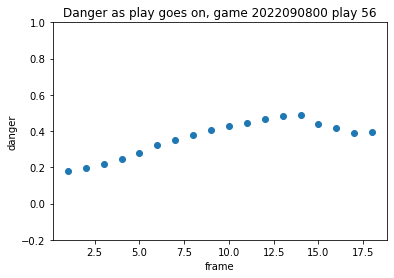

<Figure size 432x288 with 0 Axes>

In [4]:
import Circle_Interaction as circles
play = circles.interpret_play(2022090800, 56, week = 1)
circles.Scatterplot_Dangers(play)

![Alt text](56.gif)

In this passing play, we have graphed the defensive players as red x's, the ballcarrier as a brown (color of the football) circle, and his offensive teammates as blue circles. As we can see, the defense does a good job converging on the ball carrier, with 3 players from three different directions quickly heading towards the runner. This is echoed in the scatterplot of the play shown above. There is a brief moment at the end where the danger drops, which is common in most plays, as defenders not immediately involved in the tackle tend to slow down once they decide the play is essentially over, resulting in their positioning relative to the runner getting worse.

Note that the animation is a heatmap, where the darker the outer edge of a sector is, the higher the danger is in that direction.

Note also that these animations were produced with “play.plot_play()”. There was an issue displaying that in the notebook, so we saved and then inserted the animations manually.

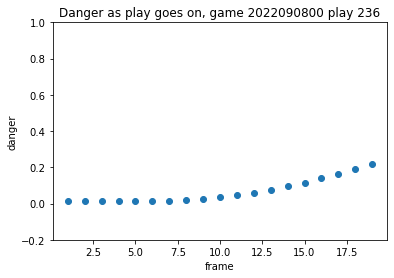

<Figure size 432x288 with 0 Axes>

In [2]:
play2 = circles.interpret_play(2022090800, 236, week = 1)
circles.Scatterplot_Dangers(play2)

![Alt text](236.gif)

Above is a an animation and graph of a play that  results in a walk in deep passing touchdown. As you can see from both the chart and the animation, the ballcarrier catches the ball with lots of open space around him, and then the danger increases as he gets close to the sideline and as the defender behind him begins to catch up.

Finally, we re-examine the play from the intro of the notebook, a huge run with lots of missed tackles.

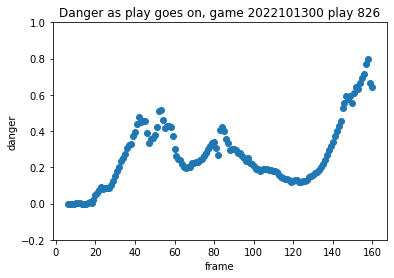

<Figure size 432x288 with 0 Axes>

In [12]:
play3 = circles.interpret_play(2022101300, 826, week = 6)
circles.Scatterplot_Dangers(play3)

Once again, the frame-by-frame Danger graph is a very accurate representation of what is going on on the field; you can easily use the peaks to identify the moment where the ballcarrier is surrounded and nearly tackled before he breaks away, which happens mutliple times on this play

While our graphical examples are compelling, finding numerical correlation is tricky. Our metric measures how well a defense surrounds a runner at any given time on the play, however a defense surrounding a ballcarrier doesn't guarantee they make the tackle; the defenders could whiff, or the runner could make a good move to avoid them.

Therefore,it can be difficult to find an existing metric to compare ours too. The best we could think of, was to compare danger at a given time to the yards gained for the rest of the play afterwards

To do so, we clean the data by limiting the yards gained after any frame to 10 calling this "trimmed yards remaining” to reduce the effect of runaway touchdowns, where a player escapes a crowd of defenders to run another 80 yards, and because our metric only takes into consideration factors within 10 yards of the runner. 

We also cut out plays where a penalty or touchdown occurred (scoring can artificially limit yardage), as well as any frames before the ball was snapped, to eliminate noise from pre snap movements. We left in frames before a catch or a scramble, as while the ball is in the air, or while a quarterback is moving towards the line of scrimmage, defenders tend to already be creeping towards the soon-to-be runner,. This process occurs in the files Cleaning.py and Perform Analysis.py, which are in the appendix. Also in the appendix, is a file called correlation.py, which runs linear regression on the total danger per frame compared to trimmed yards remaining


In [21]:
import Correlation as C
C.get_correlation()

r-squared for comparing Frame-Danger to Trimmed Yards Left is 0.37228069112586004


We found an r-squared value of 0.37, which isn't great. However, once again, given that a few broken tackles can result in massive gains for the offense in spite of good defensive positioning this is a solid number. Our goal was to quantify how well a defense surrounds a runner at any given time, and we believe that even this low correlation, as well as the graphical examples above, are enough to show that our metric succeeds in doing so.

<font size = "+2"><b>Appendix</b><font>

<a href="https://github.com/WillQualls/Big-Data-Bowl-2024UCONNTEAM">Here</a> is a link to a github containing our code for cleaning and analyzing the data, as well as the code for powering the circles.

To get the overall dangers for a circle, create the circle inside circle interaction by calling interpret_play(game, play, week). Then call Get_Dangers_And_Centers(circle), which will return a list of the overall danger per frame on the play,followed be ballcarrier's location on every frame. To get the slicewise dangers, call Get_Dangers which resutns the same thing, except the first item it returns is a dictionary of slicewise dangers, rather than overall danger.

Note that it assumes all the data provided to us by the competition is in a file called "Data". We couldn't upload this to github due to the platform's space constraints.

You must run Cleaning.Py and the main included function clean() before doing anything else, everything else is powered by those cleaned files. You then need to run Perform Analysis.py and call the function analyze, which will then populate data so you can run the function inside Correlation.py as done in the main section of the notebooks.

The github also contains copies of all the images in the notebook, in case they don't load for whatever reason. We don't consider the formulas to be figures, we just couldn't write them inline with the text and have them look neat, apologies if we misinterpreted that.

<font size = "+2"><b>Acknowledgements</b><font>

Thank you to Professor Jinbo Bi PhD, for supervising this project, and to uconn PhD candidate and M.S.in Computer Science Blake Gaines for helping us to understand the math neccesary to power our metric.